<a href="https://colab.research.google.com/github/NateshReddy/Denoising-Algorithm-Implementation-/blob/master/cifar10_DNCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  DeNoising Convolutional Neural Network for Cifar10 dataset




In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
batch_size = 32
num_classes = 10
epochs = 30
saveDir = "/content/drive/My Drive/denoising task/model2_dncnn"

In [4]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [5]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

## Adding Noise

In [6]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

## Displaying noisy images

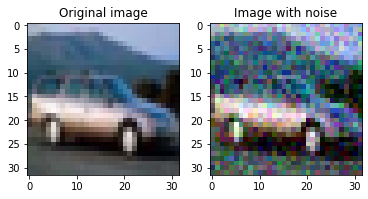

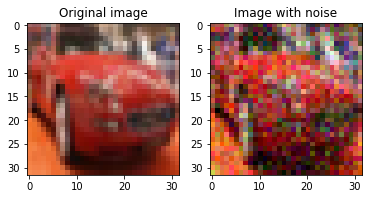

In [7]:
idx = 4
for i in range(2):
  plt.subplot(1,2,1)
  plt.imshow(train_data_clean[idx])
  plt.title('Original image')
  plt.subplot(1,2,2)
  plt.imshow(train_data_noisy[idx])
  plt.title('Image with noise')
  plt.show()
  idx = idx + 1

# DNCNN

In [ ]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(3, (3, 3), padding='same')(x)
output_img = Activation('tanh')(x)

In [ ]:
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_dncnn_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# Training

In [ ]:
history = model.fit(train_data_noisy, train_data_clean,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_data_noisy, test_data_clean),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 161s 3ms/step - loss: 0.0020 - val_loss: 0.0020

Epoch 00001: val_loss improved from 0.00209 to 0.00195, saving model to /content/drive/My Drive/denoising task/model2_dncnnAutoEncoder_Cifar10_dncnn_weights.01-0.00-0.00.hdf5
Epoch 2/100
50000/50000 [==============================] - 161s 3ms/step - loss: 0.0019 - val_loss: 0.0023

Epoch 00002: val_loss did not improve from 0.00195
Epoch 3/100
50000/50000 [==============================] - 160s 3ms/step - loss: 0.0018 - val_loss: 0.0021

Epoch 00003: val_loss did not improve from 0.00195
Epoch 00003: early stopping


In [9]:
dae = load_model('/content/drive/My Drive/denoising task/model2_dncnn/model2_dncnnAutoEncoder_Cifar10_dncnn_weights.01-0.00-0.00.hdf5')

In [10]:
test_data_denoised = dae.predict(test_data_noisy)

## Visualize original image, noisy image and denoised image

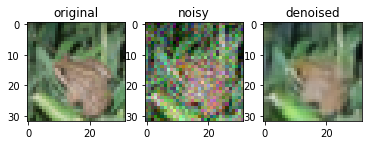

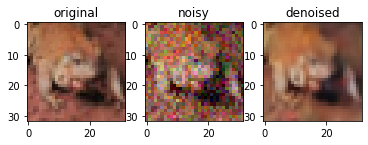

In [11]:
idx = 4
for i in range(2):
  plt.subplot(1,3,1)
  plt.imshow(test_data_clean[idx])
  plt.title('original')
  plt.subplot(1,3,2)
  plt.imshow(test_data_noisy[idx])
  plt.title('noisy')
  plt.subplot(1,3,3)
  plt.imshow(test_data_denoised[idx])
  plt.title('denoised')
  plt.show()
  idx = idx + 1

## Evaluation with the test dataset

we have calculated the PSNR and SSIM of the whole CIFAR10 test set. 

In [12]:
from skimage import metrics
psnr = metrics.peak_signal_noise_ratio(test_data_clean,test_data_denoised)
ssim = metrics.structural_similarity(test_data_clean,test_data_denoised,multichannel=True)
print("PSNR:",psnr,"\nSSIM:",ssim)

PSNR: 27.085994752312146 
SSIM: 0.9804937060975822
